In [4]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#ADFF02",
    "#8F00FF",
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams["figure.figsize"] = 12, 8

In [3]:
%load_ext lab_black

# helper functions

To facilitate training our perceptron, we have provided a function to read image files (`load_image_files`) of a given digit (`n`), from a provided path (`path=...`), convert them to a numpy matrix, and finally flatten that numpy matrix into a vector. The function load_image_files returns all of the vectors corresponding to pixels in handwritten digits of n from the MNIST dataset. This function returns "images" of $28 \times 28 = 784$ zeroes and ones, corresponding to whether the image was white or black at a given location. 

> For convenience, each "image" returned to you is a single vector of length 784. Functions that might be useful throughout this notebook:

- `x.flatten()` (take a N-dimensional numpy array and make it one-dimensional)

- `random.sample` -- choose from the list of images

- `np.dot()` -- compute the dot product of two vectors: the sum of the product of the coordinates.

- `np.reshape()` -- reshapes a vector to a matrix

- `x.imshow()` -- visualize a matrix as an image (including heatmaps)

In [14]:
# dimension of all images
DIM = (28, 28)

# flattened imahe
N = DIM[0] * DIM[1]

In [6]:
def load_image_files(n, path="images/"):
    """loads images of given digit and returns a list of vectors"""
    # initialize empty list to collect vectors
    images = []
    # read files in the path
    for f in sorted(os.listdir(os.path.join(path, str(n)))):
        p = os.path.join(path, str(n), f)
        if os.path.isfile(p):
            i = np.loadtxt(p)
            # check image dimension
            assert i.shape == DIM
            # flatten i into a single vector
            images.append(i.flatten())
    return images


# load images of '0' and '1'
img1 = load_image_files(0)
img0 = load_image_files(1)

In [11]:
def classify_image(W, image):
    """use weight matrix W to determine digit in image"""
    # if dot product > 0, return 1; otherwise 0
    y = (np.dot(image, W) > 0).astype(int)
    return y

In [12]:
def update_weights(W, images, labels):
    """updates weight matrix W based on training (image,label) pairs"""

    # loop through images and labels
    for image, label in zip(images, labels):
        # predict image label
        pred_label = classify_image(W, image)
        # update only if prediction is wrong
        if pred_label != label:
            # predicted 0 but label is 1
            if label == 1:
                W += image
            # predicted 1 but label is 0
            else:
                W -= image

    # return updated weights
    return W

In [13]:
def compute_accuracy(W, images, labels):
    """computes accuracy on a list of images"""
    # initialize count at 0
    n_correct = 0
    # loop through image list
    for i, image in enumerate(images):
        # increment count by each time we correctly classify an image
        n_correct += (labels[i] == classify_image(W, image)).astype(int)

    # accuracy is total correct / total
    return n_correct / len(images)

# classify 0 vs. 1

## train perceptron
Write an implementation of the perceptron learning algorithm that first loads images for the digit "0" and then for the digit "1". Start with random weights from a normal distribution. Compute the average accuracy on blocks of 25 items and plot this accuracy until you think it won't get better.

In [15]:
def train_perceptron(digit1, digit2, n_samples=25, epoch=200):
    """train perceptron on (image, label) pairs for given steps"""

    # load images for two digits to compare
    img1 = load_image_files(digit1)
    img2 = load_image_files(digit2)

    # initialize empty list to collect accuracies
    accuracies = []
    # initilaize random weights from standard normal
    W = np.random.normal(0, 1, size=N)

    # iterate through each epoch
    for i in tqdm(range(epoch)):

        # randomly sample images for '0'
        sample1 = random.sample(img1, n_samples)
        # randomly sample images for '1'
        sample2 = random.sample(img2, n_samples)

        # train on chosen samples
        W = update_weights(W, sample1 + sample2, [0] * n_samples + [1] * n_samples)
        # evaluate performance on all images
        accuracy = compute_accuracy(W, img1 + img2, [0] * len(img1) + [1] * len(img2))
        accuracies.append(accuracy)

    # return accuracies and final weights
    return accuracies, W

In [16]:
# train on 25 examples for given number of epochs
n_samples, epochs = 25, 500
accuracies, trained_W = train_perceptron(0, 1, n_samples, epochs)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'training accuracy')

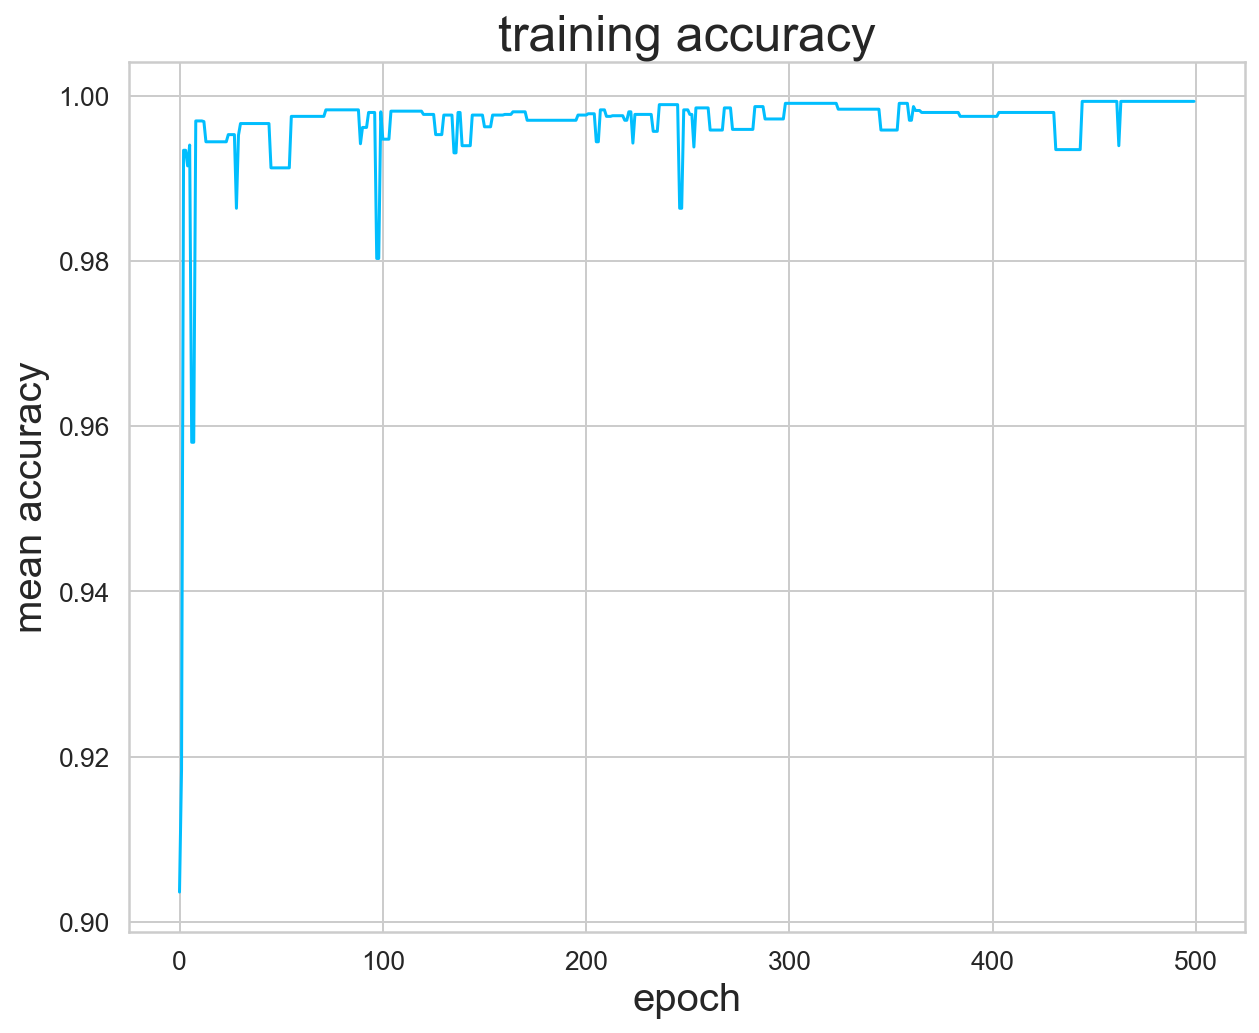

In [18]:
# plot accuracy as a function of epoch
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(epochs), accuracies)
ax.set_xlabel("epoch", fontsize=20)
ax.set_ylabel("mean accuracy", fontsize=20)
ax.set_title("training accuracy", fontsize=25)

## learned weights

Reshape (`numpy.reshape`) your weight vector after training so that it is a 28 $
\times$ 28 matrix. This corresponds to the weight assigned to each pixel in the image. Show a picture of this weight matrix and interpret it in a sentence or two. What do large negative and large positive values mean, intuitively? What do numbers near zero mean? Why does this matrix look the way that it does, in terms of where large positive and negative terms are located?

In [19]:
# reshape weights back to 28 * 28
trained_W_2d = np.reshape(trained_W, DIM)

(-0.5, 27.5, 27.5, -0.5)

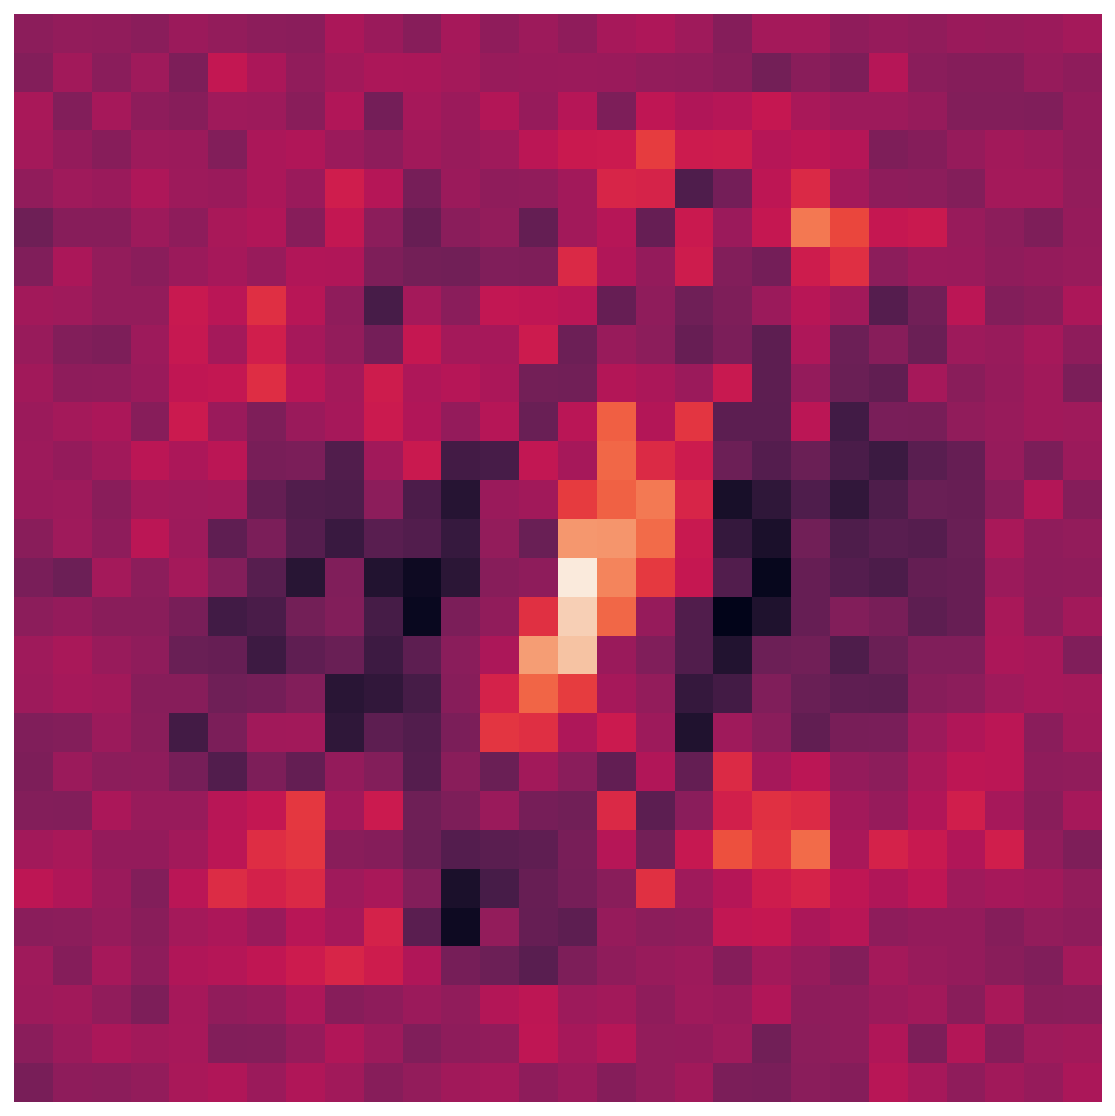

In [21]:
# plot weight matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(trained_W_2d)
ax.axis("off")

## normalization
What should you expect to happen if you set the elements of the weight vector which are close to zero to be actually zero? Do this for the 10, 20, 30, ... 780 weight values closest to zero in absolute value (use a loop) and plot the resulting accuracies on 1000 random classifications of “0” vs “1”. What does this tell you about the proportion of the image which is diagnostic about “0” vs “1”?

In [22]:
def zeroing_weights(W, n_closest):
    """set n weights closest to 0 to 0"""
    # sort absolute weights
    sorted_W = np.sort(np.abs(W))
    # find nth closet value to 0
    cutoff = sorted_W[n_closest - 1]
    # set values closer to 0 with 0
    zeroed_W = np.where(np.abs(W) <= cutoff, 0, W)
    # return zeroed weights
    return zeroed_W

In [23]:
# load images for '0' and '1'
zeroes = load_image_files(0)
ones = load_image_files(1)

In [24]:
# randomly choose 1000 examples
images = random.sample(zeroes, 1000) + random.sample(ones, 1000)
labels = [0] * 1000 + [1] * 1000

In [25]:
# initialize empty list to collect accuracies
new_accuracies = []
# number of weights to set to 0
n_closests = [i * 10 for i in range(1, 79)]

In [26]:
# loop through zeroed weights to get new accuracies
for n in n_closests:
    # zero given number of weights
    new_W = zeroing_weights(trained_W, n)
    # get new accuracy
    acc = compute_accuracy(new_W, images, labels)
    # append to list
    new_accuracies.append(acc)

Text(0.5, 1.0, 'does zeroing weights hurt accuracy?')

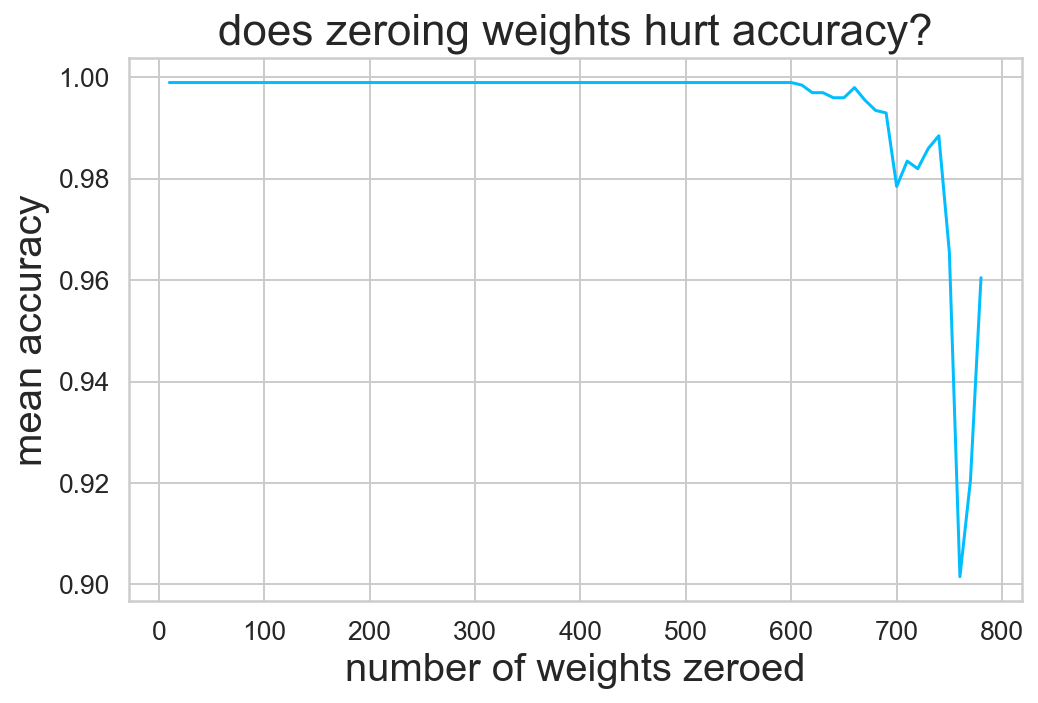

In [27]:
# plot accuracy as a function of how many weights to zero
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_closests, new_accuracies)
ax.set_xlabel("number of weights zeroed", fontsize=20)
ax.set_ylabel("mean accuracy", fontsize=20)
ax.set_title("does zeroing weights hurt accuracy?", fontsize=22)

# generalize to all image pairs
Next show a matrix of the classification accuracy of each pair of digits after enough training. Make this a plot (with colors for accuracy rather than numbers). Does it match your intuitions about which pairs should be easy vs. hard? Why or why not?

In [28]:
def get_accuracy_matrix(n_num):
    """get maxtrix with classification accuracy"""

    # initialize matrix with all 1's
    acc_matrix = np.ones([n_num, n_num])

    # loop through digit pairs
    for digit1 in range(n_num - 1):
        for digit2 in range(digit1 + 1, n_num):
            # get accuracies after 100 epochs
            acc, _ = train_perceptron(digit1, digit2, 25, 100)
            # replace value in matrix with final accuracy
            acc_matrix[digit1, digit2] = acc[-1]
            acc_matrix[digit2, digit1] = acc[-1]

    # return matrix
    return acc_matrix

In [29]:
def plot_accuracy_matrix(acc_matrix, n_num):
    """plot classification accuracy using a heatmap"""

    # generate heatmap
    fig, ax = plt.subplots(figsize=(8, 8))
    g = ax.imshow(acc_matrix, cmap="Blues")
    ax.set_xticks(range(0, n_num))
    ax.set_yticks(range(0, n_num))
    ax.set_title("accuracy matrix", fontsize=20)

    # add color bar
    fig.colorbar(g, ax=ax)

In [31]:
sns.set_style("whitegrid", {"axes.grid": False})

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

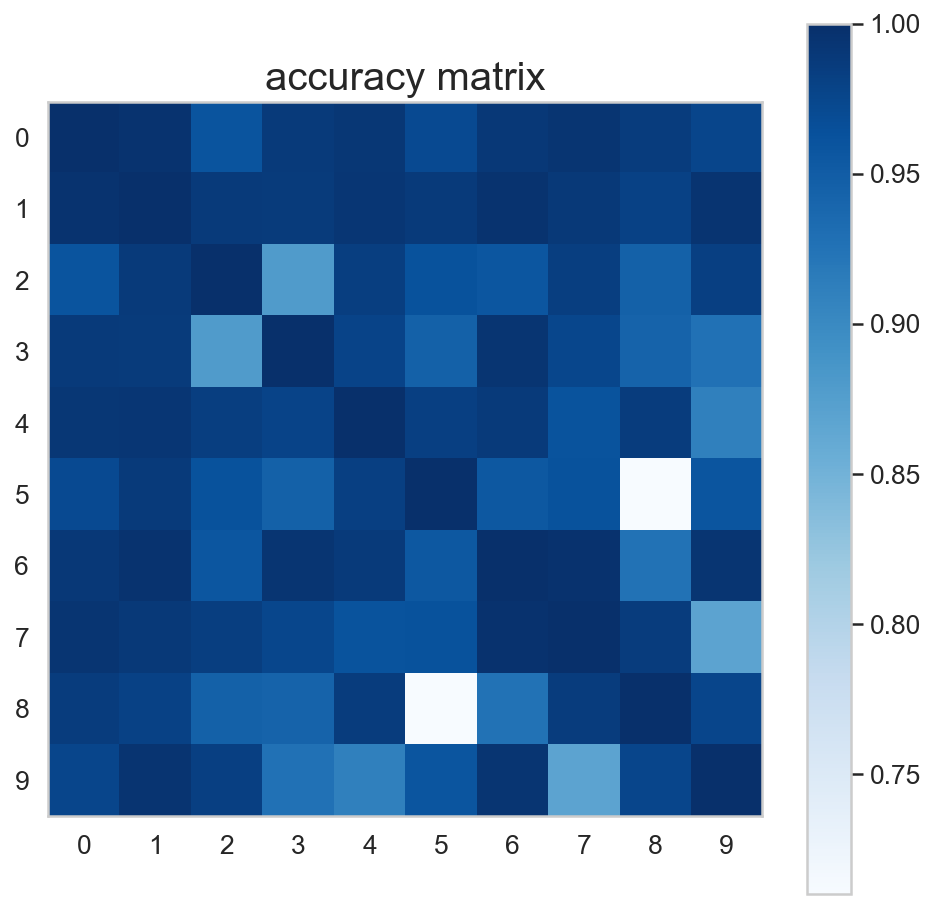

In [32]:
# do it for 0 to 9
acc_matrix = get_accuracy_matrix(10)
plot_accuracy_matrix(acc_matrix, 10)